# ECE381K Final Project

The goal of this project is to communicate over a real baseband channel with impulse response:
$$
h[n] = \begin{bmatrix}
    0.8037 & 0.7209 & -0.3179 & -0.3395 & -0.2455 & -0.0897 & -0.1079 & 0.2267 & -0.1602
\end{bmatrix}^T
$$

We will analyze given a fixed transmit filter and matched receiver filter $g_{TX}[n] = g_{RX}[n] = \frac{1}{\sqrt{T}}\delta[n]$, fixed signal energy per dimension $\bar{\mathcal{E}_s} = 1$, and fixed noise power $\frac{N_0}{2}=0.15$

In [20]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.fft import fft
import matplotlib.pyplot as plt

import sys
sys.path.append('./src')

import utils, encoders, OFDM, plots

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
h = np.array([0.8037, 0.7209, -0.3179,-0.3395, -0.2455, -0.0897, -0.1079, 0.2267, -0.1062])
# h = np.array([1, 0.5])
E_bar = 1
No = 0.3


## ISI Channel Fundamentals

For this project, we will assume T = 1
First we determine $q[n]$ and plot its frequency response

First, we find the pulse response
$$
g_{TX}[n] = \frac{1}{\sqrt{T}}\delta[n] \\
p[n] = h[n] \ast g_{TX}[n] \\
\Longrightarrow p[n] = h[n] \\
$$

We can then find an expression for $q[n]$
$$
\begin{equation*}
    \begin{split}
    q[n] &\overset{\Delta}{=} T \cdot p[n] \ast \frac{p^*[-n]}{||p||} \\
    \\
    \Longrightarrow q[n] &= h[n] \ast \frac{h^*[-n]}{||h||}
    \end{split}
\end{equation*}
$$


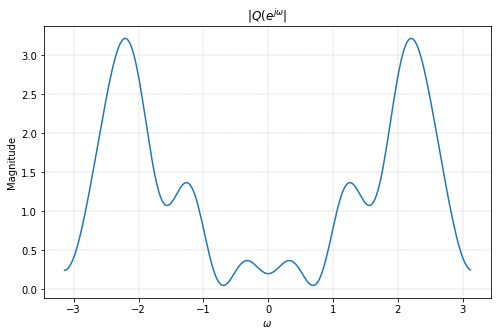

In [3]:
__n__ = 256 # Adjust to change the smoothness of the produced figure

q = np.convolve(h, np.conj(h[::-1]) / np.sqrt(h @ h))
Q = fft(q, __n__)

fig = plt.figure(figsize=(8, 5))
plt.plot(np.arange(-np.pi, np.pi, 2*np.pi/__n__), np.abs(Q))
plt.title('$|Q(e^{j\omega}|$')
plt.ylabel('Magnitude')
plt.xlabel('$\omega$')
plt.grid(True, ls='--', lw=0.4)
plt.show()


Next we determine the matched filter bound $SNR_{MFB}$ for this channel

$$
SNR_{MFB} \overset{\Delta}{=} \frac{\bar{\mathcal{E}_s} \cdot ||p||^2}{\frac{N_0}{2}}
$$

It is important for us to note that the inner product $||p||^2 = p^Tp$

In [4]:
p = h
mag_p = p @ p
snr_mfb = E_bar * mag_p / (No/2)
print(f'SNR(mfb) = {snr_mfb:.2f} ({utils.lin_to_db(snr_mfb):.2f} db)')

SNR(mfb) = 10.16 (10.07 db)


Now we can find the associated data rate for a given probability.
For example, we take $P_e < 10^{-4}$, which corresponds to a gap of $\Gamma = 6.6$ in dB.

Using the Shannon Limit for baseband channels, $b \leq \frac{1}{2}log_2(1 + \frac{SNR}{\Gamma})$, we find:

In [5]:
gap = 6.6

b = 1/2 * np.log2(1 + snr_mfb/utils.db_to_lin(6.6))
print(f'The maximum spectral efficiency we can expect on this channel is: {b:.4f} bps/Hz')

The maximum spectral efficiency we can expect on this channel is: 0.8443 bps/Hz


We can find the expected probability of error is we are to send symbols over this channel without equalization. If we transmit with 2PAM, we wil have 

$P_e = P_b \leq Q(\sqrt{SINR})$

We have 

$SINR = \frac{S}{ISI + \sigma^2}$

$S = |q[0]|^2 \cdot \bar{\mathcal{E}_s}$

$ISI = \sum_{k\neq0}{|q[k]|^2 \cdot \bar{\mathcal{E}_s}}$

$\sigma^2 = \frac{N_0}{2}$

In [6]:
c = len(q) // 2 # Center index

S = E_bar * (q[c] ** 2)
ISI = E_bar * np.sum((np.concatenate((q[:c], q[c+1:])) ** 2))
sig2 = No/2

SINR = S / (ISI + sig2)

Pe = utils.qfunc(np.sqrt(SINR))

print(f'The SINR we find on this channel without equalization is {SINR:0.4f} ({utils.lin_to_db(SINR):.2f} dB)')
print(f'The expected probability of error for symbol by symbol detection with no equalization is: {Pe:.5f}')

The SINR we find on this channel without equalization is 1.3545 (1.32 dB)
The expected probability of error for symbol by symbol detection with no equalization is: 0.12224


Now we can simulate transmission over this exact channel and determine an empirical probability of error for 100k bits

In [7]:
n_bits = 10 ** 6

pam = encoders.MPAM(M=2)
b = utils.generate_bits(n_bits)

symbols = pam.encode_bits(b)

signal = np.convolve(symbols, q)[len(h)-1:-len(h)+1]
noise = np.sqrt(No/2) * (np.random.randn(*signal.shape))
noise = np.convolve(noise, p[::-1]/np.sqrt(mag_p))[:-len(p)+1]
signal = signal +  noise

b_hat = pam.decode_symbols(signal)

empirical_pe = utils.probability_of_bit_error(b, b_hat)
print(f'The empirical probability of error we simulate is: {empirical_pe:.4f}')

The empirical probability of error we simulate is: 0.1259


We can see that our empirical estimation is incredibly close to the theoretical value, off by less than 1%

## ZF and MMSE FIR Equalization

Here I design 33 tap ZF and MMSE FIR equalizers to improve performance

In [8]:
from scipy.linalg import toeplitz # For generating U

For this channel, we have that

$$q[n] = p[n] \ast \frac{p^*[-n]}{||p||}$$

A 33 tap equalizer contains information for the 16 preceeding and succeeding symbols as well as the symbol at detection time.
Its worth noting these 16 taps come from the number of ISI taps in $q[n]$, which in this case is 16.

It then follows that 

$$
\underline{\textbf{r}}[n] \overset{\Delta}{=} \begin{bmatrix}
    z[n-8] \\
    \vdots \\
    z[n] \\
    \vdots \\
    z[n+8]
\end{bmatrix}

\hspace*{1cm}

\textbf{U} = \begin{bmatrix}
    q_0 & q_1 & q_2 & \dots & 0 \\
    0 & q_0 & q_1 & \dots & 0 \\
    \vdots & \vdots & \vdots& \ddots & \vdots\\
    0 & 0 & 0 & \dots & q_{33}
\end{bmatrix}

\hspace*{1cm}

\underline{\textbf{b}}[n] = \begin{bmatrix}
    b[n-16] \\
    \vdots \\
    b[n] \\
    \vdots \\
    b[n+16]
\end{bmatrix}

\hspace*{1cm}

\underline{\textbf{w}}[n] = \begin{bmatrix}
    \mathcal{w}[n-8] \\
    \vdots \\
    \mathcal{w}[n] \\
    \vdots \\
    \mathcal{w}[n+8]
\end{bmatrix}
$$

Using these formulations, we arrive at the matrix model of the channel for the 33 tap equalizer

$\underline{\textbf{r}} = \textbf{U\underline{b}} + \textbf{\underline{w}}$

Then, the Finite Impulse Response Zero-Forcing (FIR ZF) equalizer 

$\textbf{c}_{zf} = (UU^*)^{-1}\underline{u}_0$

Where $\underline{u}_0$ refers to the center column of $\textbf{U}$, equivalently this is $\underline{q}$

In [9]:
U = toeplitz(np.concatenate((q[[0]], np.zeros(len(q)-1))), 
                        np.concatenate((q, np.zeros(len(q)-1))))
Czf = np.linalg.inv(U @ np.conj(U.T)) @ q
print('The 33 tap FIR-ZF equalizer for this channel is: ', Czf, '^T')

The 33 tap FIR-ZF equalizer for this channel is:  [ 0.08707012  0.0676916  -0.0810657   0.28645785  0.03856282  0.1014839
  0.54102863 -0.63167323  1.60995852 -0.63167323  0.54102863  0.1014839
  0.03856282  0.28645785 -0.0810657   0.0676916   0.08707012] ^T


In a more human, readable format,

$$

C_{zf} = \begin{bmatrix}
    0.087 \\ 0.067 \\ -0.081 \\  0.286 \\ 0.038 \\ 0.101 \\ 0.541 \\ -0.631 \\ 1.609 \\ -0.631 \\ 0.541 &\\0.101 \\0.038 \\ 0.286 \\-0.081 \\  0.067  \\ 0.087
\end{bmatrix}
$$

Now we estimate the SINR of the channel

We need to use the definition of our noise vector from the zf generation, and more importantly we need its autocorrelation. F is the matrix version of the matched filter, an anticausal matrix which filters the noise (whereas the signal is filtered both by the pulse response AND the matched filter, represented by q)

$$
\underline{\textbf{w}}[n] = \begin{bmatrix}
    \mathcal{w}[n-8] \\
    \vdots \\
    \mathcal{w}[n] \\
    \vdots \\
    \mathcal{w}[n+8]
\end{bmatrix}

\hspace*{3cm}

R_{\underline{w}} = \mathbb{E}[\underline{\textbf{w}}[0]\underline{\textbf{w}}[0]^*] = F \frac{N_0}{2} F^*
$$

Then, we know that


$$
\begin{align}
    \sigma_{zf}^2 &= \textbf{\underline{C}}_{zf} R_{\underline{w}} \textbf{\underline{C}}_{zf}^* \\
                &= \frac{N_0}{2} \cdot \textbf{\underline{C}}_{zf} F  F^* \textbf{\underline{C}}_{zf}^*
\end{align}
$$

In [10]:
F = toeplitz(np.concatenate((p[[0]], np.zeros(len(q)-1))),
    np.concatenate((p, np.zeros(len(q)-1))))

Rw = No/2 * F @ np.conj(F).T / mag_p
sig2_zf = Czf @ Rw @ np.conj(Czf).T
print(f'The zero forcing noise variance: {sig2_zf:.2f}')

power_vec = (Czf @ U) 
c = len(power_vec) // 2
Pr = power_vec[c] ** 2
Pi = np.concatenate((power_vec[:c], power_vec[c+1:])) @ np.concatenate((power_vec[:c], power_vec[c+1:])).T

SINR = Pr * E_bar /  (Pi * E_bar + sig2_zf)

print(f'The corresponding SINR is : {SINR:.2f} ({utils.lin_to_db(SINR):.2f} dB)')

b = 1/2 * np.log2(1 + SINR/utils.db_to_lin(gap))

print(f'Using the same gap as previously ({gap} dB), the spectral efficiency is {b:.2f} bps/Hz')

The zero forcing noise variance: 0.17
The corresponding SINR is : 3.80 (5.79 dB)
Using the same gap as previously (6.6 dB), the spectral efficiency is 0.44 bps/Hz


Since the spectral efficiency is less than 1 bps/Hz, we are limited to 2PAM as the simplest possible form of encoding, assuming we do transmit with 2PAM, we have $P_e \leq Q(\sqrt{SINR})$

In [11]:
Pe = utils.qfunc(np.sqrt(SINR))

print(f'The theoretical probability of error we achieve is {Pe:.4f}')

The theoretical probability of error we achieve is 0.0257


While this isn't quite at the $10^{-4}$ target, we made a massive improvement over the 0.12 error with no equalization

For the minimum mean squared error FIR equalizer (MMSE FIR), we have the following formula:
*Note that since this is a baseband channel, N=1

$$
C_{mmse} = (\textbf{UU}^* + \frac{1}{\mathcal{E_s}} \textbf{R}_w)^{-1}\textbf{u}_0

\hspace*{2cm}

\mathcal{E_s} = N \cdot \overline{\mathcal{E_s}}
$$

In [12]:
Cmmse = np.linalg.inv(U@np.conj(U).T + 1/E_bar * Rw) @ q
print(Cmmse)


[ 0.07133085  0.03566502 -0.04214796  0.19451777  0.04571335  0.10058017
  0.36493694 -0.41469831  1.24484771 -0.41469831  0.36493694  0.10058017
  0.04571335  0.19451777 -0.04214796  0.03566502  0.07133085]


In a human readable format, this is

$$

C_{mmse} = \begin{bmatrix}

    0.0713 \\
    0.0356 \\ 
    -0.0421 \\
    0.1945 \\
    0.0457 \\  
    0.1005 \\
    0.3649 \\
    -0.4146 \\
    1.2448 \\
    -0.4146 \\
    0.3649 \\
    0.1005 \\
    0.0457 \\
    0.1945 \\
    -0.0421 \\
    0.0356 \\
    0.0713
    
\end{bmatrix}

$$

In [13]:
sig2_mmse = Cmmse @ Rw @ np.conj(Cmmse).T
print(f'The zero forcing noise variance: {sig2_zf:.2f}')

power_vec = (Cmmse @ U) 
c = len(power_vec) // 2
Pr = power_vec[c] ** 2
Pi = np.concatenate((power_vec[:c], power_vec[c+1:])) @ np.concatenate((power_vec[:c], power_vec[c+1:])).T

SINR = Pr * E_bar /  (Pi * E_bar + sig2_mmse)

print(f'The corresponding SINR is : {SINR:.2f} ({utils.lin_to_db(SINR):.2f} dB)')

b = 1/2 * np.log2(1 + SINR/utils.db_to_lin(gap))

print(f'Using the same gap as previously ({gap} dB), the spectral efficiency is {b:.2f} bps/Hz')

The zero forcing noise variance: 0.17
The corresponding SINR is : 4.07 (6.10 dB)
Using the same gap as previously (6.6 dB), the spectral efficiency is 0.46 bps/Hz


In [14]:
Pe = utils.qfunc(np.sqrt(SINR))

print(f'The theoretical probability of error we achieve is {Pe:.4f}')

The theoretical probability of error we achieve is 0.0218


Now we simulate equalizing with both equalizers

In [15]:
n_bits = 10 ** 6

pam = encoders.MPAM(M=2)
b = utils.generate_bits(n_bits)

symbols = pam.encode_bits(b)

signal = np.convolve(symbols, q)[len(h)-1:-len(h)+1]
noise = np.sqrt(No/2) * (np.random.randn(*signal.shape))
noise = np.convolve(noise, p[::-1]/np.sqrt(mag_p))[:-len(p)+1]
signal = signal +  noise

signal_eq = np.convolve(signal, Czf)[len(h)-1:-len(h)+1]

b_hat = pam.decode_symbols(signal_eq)

empirical_pe = utils.probability_of_bit_error(b, b_hat)
print(f'The empirical probability of error using a zero-forcing equalizer we simulate is: {empirical_pe:.4f}')

The empirical probability of error using a zero-forcing equalizer we simulate is: 0.0254


In [16]:
# Reusing PAM and number of bits from previous simulation

b = utils.generate_bits(n_bits)

symbols = pam.encode_bits(b)

signal = np.convolve(symbols, q)[len(h)-1:-len(h)+1]
noise = np.sqrt(No/2) * (np.random.randn(*signal.shape))
noise = np.convolve(noise, p[::-1]/np.sqrt(mag_p))[:-len(p)+1]
signal = signal +  noise

signal_eq = np.convolve(signal, Cmmse)[len(h)-1:-len(h)+1]

b_hat = pam.decode_symbols(signal_eq)

empirical_pe = utils.probability_of_bit_error(b, b_hat)
print(f'The empirical probability of error using an MMSE equalizer we simulate is: {empirical_pe:.4f}')

The empirical probability of error using an MMSE equalizer we simulate is: 0.0217


## OFDM

Here I implement a manifestation of OFDM, using N=64 subcarriers, and a cycle-prefix length v = L + 1 = 9

In [30]:
import waterfilling

N = 64
v = 9

We begin by determining the optimal energy allocation along subchannels with waterfilling
and then calculating spectral efficiency and SNR using shannon

$$
b_n = \frac{1}{2} * log_2(1 + SNR_n)

\hspace*{2cm}

SNR_n \overset{\Delta}{=} \frac{|H_n|^2}{\sigma^2}
$$

Then, the average spectral efficiency, accounting for the cycle-prefix symbols (which contain no data), and its effective SNR:

$$
\overline{b} = \frac{b}{N+v}

\hspace*{2cm}

SNR_{ofdm} = 2^{2\overline{b}-1}
$$

./src\plots.py:49: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


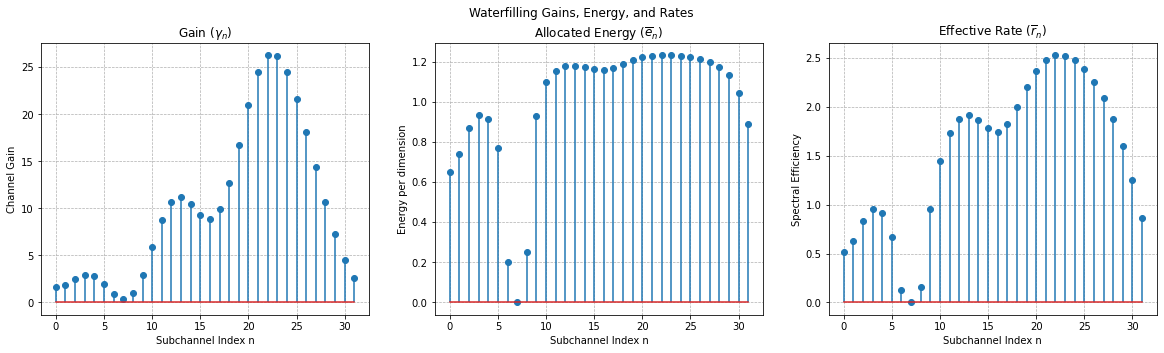

In [105]:
gains = np.abs(fft(h, 64)) ** 2 / (No/2)
optimal_power = waterfilling.waterfill_alloc(gains, N * E_bar)
b = 1/2 * np.log2(1 + optimal_power * gains)

c = len(gains) // 2
plots.plot_waterfilling_info(gains[c:], optimal_power[c:], b[c:])

In [109]:
b_bar = (b /  (N + v)).sum()
SNRofdm = (2**(2*b_bar)-1)
Pe = utils.qfunc(np.sqrt(SNRofdm))

print(f'The effective rate we comput is {b_bar:.4f}\nThe effective SNR this pairs to is {SNRofdm:.4f} ({utils.lin_to_db(SNRofdm):.2f} dB)')
print(f'Due to a neat property of 2PAM and QPSK, they share probability of bit errors, \n\tand therefore we can estimate the bit error with trivial computation to be Pe = {Pe:0.4f}')

The effective rate we comput is 1.3419
The effective SNR this pairs to is 5.4251 (7.34 dB)
Due to a neat property of 2PAM and QPSK, they share probability of bit errors, 
	and therefore we can estimate the bit error with trivial computation to be Pe = 0.0099


This is a massive improvement over our ZF and MMSE equalizers. It's worth noting that this is not totally optimal in the sense that an SVD based equalizer will perform better on this channel, but it would require $O(N^2)$ feedback from the receiver estimating the channel to the transmitter to provide an optimal precoding, whereas OFDM only needs to feedback $O(N)$ power-allocations

In [110]:
from tqdm import trange

In [111]:
packets = 10**4

In [ ]:

transmitter = OFDM.OFDM_transmitter(v)
receiver = OFDM.OFDM_receiver(v, h, N)

In [ ]:

Q = np.convolve(h, np.conj(h[::-1]))

# Create bits
N_bits = packets * N
bits = utils.generate_bits(N_bits)
pe_mean = 0

# For each block symbol
for i in (window := trange(packets)):
    # Pass through transmitter
    bits_sent = bits[N*i:N*i+N]
    tx_signal = transmitter(bits_sent)
    
    # Pass through channel
    signal = np.convolve(tx_signal, Q, 'full')[len(h)-1:1-len(h)]

    # Add AWGN noise
    noise = np.sqrt(No/2) * (np.random.randn(*signal.shape))
    noise = np.convolve(noise, h[::-1]/np.sqrt(mag_p))[:-len(h)+1]
    noisy_signal = signal + noise

    # Pass through receiver
    bits_received = receiver(noisy_signal)
    pe = utils.probability_of_bit_error(bits_sent, bits_received)
    pe_mean = pe_mean * (i/(i+1)) + pe/(i+1)
    window.set_description(f'Empirical Pe: {pe_mean*100:.2f}%')
pe_mean